There are more advanced SQL features, mostly focused on using BigQuery.

## 1. JOINs and UNIONs

### JOINs
We can use an INNER JOIN to pull rows from both tables where the value in the Pet_ID column in the owners table has a match in the ID column of the pets table.

Note that with a UNION, the data types of both columns must be the same, but the column names can be different. (So, for instance, we cannot take the UNION of the Age column from the owners table and the Pet_Name column from the pets table.)

We use UNION ALL to include duplicate values - you'll notice that 9 appears in both the owners table and the pets table, and shows up twice in the concatenated results. If you'd like to drop duplicate values, you need only change UNION ALL in the query to UNION DISTINCT.


### UNIONs
JOINs horizontally combine results from different tables. If you instead would like to vertically concatenate columns, you can do so with a UNION. The example query below combines the Age columns from both tables.

Note that with a UNION, the data types of both columns must be the same, but the column names can be different. (So, for instance, we cannot take the UNION of the Age column from the owners table and the Pet_Name column from the pets table.)

We use UNION ALL to include duplicate values - you'll notice that 9 appears in both the owners table and the pets table, and shows up twice in the concatenated results. If you'd like to drop duplicate values, you need only change UNION ALL in the query to UNION DISTINCT.

### Example

In [ ]:
# Query to select all stories posted on January 1, 2012, with number of comments
join_query = """
             WITH c AS
             (
             SELECT parent, COUNT(*) as num_comments
             FROM `bigquery-public-data.hacker_news.comments` 
             GROUP BY parent
             )
             SELECT s.id as story_id, s.by, s.title, c.num_comments
             FROM `bigquery-public-data.hacker_news.stories` AS s
             LEFT JOIN c
             ON s.id = c.parent
             WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
             ORDER BY c.num_comments DESC
             """

# Run the query, and return a pandas DataFrame
join_result = client.query(join_query).result().to_dataframe()
join_result.head()

In [ ]:
# Query to select all users who posted stories or comments on January 1, 2014
union_query = """
              SELECT c.by
              FROM `bigquery-public-data.hacker_news.comments` AS c
              WHERE EXTRACT(DATE FROM c.time_ts) = '2014-01-01'
              UNION DISTINCT
              SELECT s.by
              FROM `bigquery-public-data.hacker_news.stories` AS s
              WHERE EXTRACT(DATE FROM s.time_ts) = '2014-01-01'
              """

# Run the query, and return a pandas DataFrame
union_result = client.query(union_query).result().to_dataframe()
union_result.head()

### 1. Exercise

Here, you'll use different types of SQL **JOINs** to answer questions about the [Stack Overflow](https://www.kaggle.com/stackoverflow/stackoverflow) dataset.

Before you get started, run the following cell to set everything up.

The code cell below fetches the `posts_questions` table from the `stackoverflow` dataset.  We also preview the first five rows of the table.

In [25]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "stackoverflow" dataset
dataset_ref = client.dataset("stackoverflow", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "posts_questions" table
table_ref = dataset_ref.table("posts_questions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

ModuleNotFoundError: No module named 'google'

In [18]:
# Construct a reference to the "posts_answers" table
table_ref = dataset_ref.table("posts_answers")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

NameError: name 'dataset_ref' is not defined

1) How long does it take for questions to receive answers?

You're interested in exploring the data to have a better understanding of how long it generally takes for questions to receive answers. Armed with this knowledge, you plan to use this information to better design the order in which questions are presented to Stack Overflow users.

With this goal in mind, you write the query below, which focuses on questions asked in January 2018. It returns a table with two columns:

    q_id - the ID of the question

    time_to_answer - how long it took (in seconds) for the question to receive an answer


In [19]:
# Your code here
correct_query = """
              SELECT q.id AS q_id,
                  MIN(TIMESTAMP_DIFF(a.creation_date, q.creation_date, SECOND)) as time_to_answer
              FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
                  Left Join `bigquery-public-data.stackoverflow.posts_answers` AS a
              ON q.id = a.parent_id
              WHERE q.creation_date >= '2018-01-01' and q.creation_date < '2018-02-01'
              GROUP BY q_id
              ORDER BY time_to_answer
              """

# Run the query, and return a pandas DataFrame
correct_result = client.query(correct_query).result().to_dataframe()
print("Percentage of answered questions: %s%%" % \
      (sum(correct_result["time_to_answer"].notnull()) / len(correct_result) * 100))
print("Number of questions:", len(correct_result))

NameError: name 'client' is not defined

2) Initial questions and answers, Part 1

You're interested in understanding the initial experiences that users typically have with the Stack Overflow website. Is it more common for users to first ask questions or provide answers? After signing up, how long does it take for users to first interact with the website? To explore this further, you draft the (partial) query in the code cell below.

The query returns a table with three columns:

owner_user_id - the user ID
q_creation_date - the first time the user asked a question
a_creation_date - the first time the user contributed an answer
You want to keep track of users who have asked questions, but have yet to provide answers. And, your table should also include users who have answered questions, but have yet to pose their own questions.

With this in mind, please fill in the appropriate JOIN (i.e., INNER, LEFT, RIGHT, or FULL) to return the correct information.

Note: You need only fill in the appropriate JOIN. All other parts of the query should be left as-is. (You also don't need to write any additional code to run the query, since the check() method will take care of this for you.)

To avoid returning too much data, we'll restrict our attention to questions and answers posed in January 2019. We'll amend the timeframe in Part 2 of this question to be more realistic!

In [21]:
# Your code here
q_and_a_query = """
                SELECT q.owner_user_id AS owner_user_id,
                    MIN(q.creation_date) AS q_creation_date,
                    MIN(a.creation_date) AS a_creation_date
                FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
                    inner join `bigquery-public-data.stackoverflow.posts_answers` AS a
                ON q.owner_user_id = a.owner_user_id 
                WHERE q.creation_date >= '2019-01-01' AND q.creation_date < '2019-02-01' 
                    AND a.creation_date >= '2019-01-01' AND a.creation_date < '2019-02-01'
                GROUP BY owner_user_id
                """

3) Initial questions and answers, Part 2

Now you'll address a more realistic (and complex!) scenario. Write a query that returns the following columns:

    id - the IDs of all users who created Stack Overflow accounts in January 2019 (January 1, 2019, to January 31, 2019, inclusive)
    q_creation_date - the first time the user posted a question on the site; if the user has never posted a question, the value should be null
    a_creation_date - the first time the user posted a question on the site; if the user has never posted a question, the value should be null

Note that questions and answers posted after January 31, 2019, should still be included in the results. And, all users who joined the site in January 2019 should be included (even if they have never posted a question or provided an answer).

The query from the previous question should be a nice starting point to answering this question! You'll need to use the posts_answers and posts_questions tables. You'll also need to use the users table from the Stack Overflow dataset. The relevant columns from the users table are id (the ID of each user) and creation_date (when the user joined the Stack Overflow site, in DATETIME format).

In [29]:
# Your code here
three_tables_query = """
                SELECT u.id AS id,
                MIN(q.creation_date) AS q_creation_date,
                MIN(a.creation_date) AS a_creation_date
                FROM `bigquery-public-data.stackoverflow.users` AS u
                    left join `bigquery-public-data.stackoverflow.posts_questions` AS q ON u.id = q.owner_user_id
                    left join `bigquery-public-data.stackoverflow.posts_answers` AS a ON a.owner_user_id = u.id
                WHERE u.creation_date >= '2019-01-01' AND u.creation_date < '2019-02-01' 
                GROUP BY id
                """


4) How many distinct users posted on January 1, 2019?

In the code cell below, write a query that returns a table with a single column:

    owner_user_id - the IDs of all users who posted at least one question or answer on January 1, 2019. Each user ID should appear at most once.

In the posts_questions (and posts_answers) tables, you can get the ID of the original poster from the owner_user_id column. Likewise, the date of the original posting can be found in the creation_date column.

In order for your answer to be marked correct, your query must use a UNION.

In [28]:
# Your code here
all_users_query = """
                SELECT q.owner_user_id
                FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
                WHERE EXTRACT(DATE FROM q.creation_date) = '2019-01-01'
                UNION DISTINCT
                SELECT a.owner_user_id
                FROM `bigquery-public-data.stackoverflow.posts_answers` AS a
                WHERE EXTRACT(DATE FROM a.creation_date) = '2019-01-01'
                 """

## 2. Analytic Functions

All analytic functions have an OVER clause, which defines the sets of rows used in each calculation. The OVER clause has three (optional) parts:

    - The PARTITION BY clause divides the rows of the table into different groups. In the query above, we divide by id so that the calculations are separated by runner.
    - The ORDER BY clause defines an ordering within each partition. In the sample query, ordering by the date column ensures that earlier training sessions appear first.
    - The final clause (ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) is known as a window frame clause. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window. (Actually, analytic functions are sometimes referred to as analytic window functions or simply window functions!)

In [30]:
## Example

query = """
        SELECT *,
            AVG(time)OVER(
                          PARTITION BY id
                          ORDER BY date
                          ROWS BETWEEN 1 PRECEDING AND CURRENT ROW
                          ) as avg_time
        FROM `bigquery-public-data.runners.train_time`
        """

There are many ways to write window frame clauses:

    ROWS BETWEEN 1 PRECEDING AND CURRENT ROW - the previous row and the current row.
    ROWS BETWEEN 3 PRECEDING AND 1 FOLLOWING - the 3 previous rows, the current row, and the following row.
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING - all rows in the partition.

Of course, this is not an exhaustive list, and you can imagine that there are many more options! In the code below, you'll see some of these clauses in action.

### Three types of analytic functions
The example above uses only one of many analytic functions. BigQuery supports a wide variety of analytic functions, and we'll explore a few here. For a complete listing, you can take a look at the documentation.

1) Analytic aggregate functions
As you might recall, AVG() (from the example above) is an aggregate function. The OVER clause is what ensures that it's treated as an analytic (aggregate) function. Aggregate functions take all of the values within the window as input and return a single value.

    - MIN() (or MAX()) - Returns the minimum (or maximum) of input values
    
    - AVG() (or SUM()) - Returns the average (or sum) of input values
    
    - COUNT() - Returns the number of rows in the input

2) Analytic navigation functions
Navigation functions assign a value based on the value in a (usually) different row than the current row.

    - FIRST_VALUE() (or LAST_VALUE()) - Returns the first (or last) value in the input
    
    - LEAD() (and LAG()) - Returns the value on a subsequent (or preceding) row

3) Analytic numbering functions
Numbering functions assign integer values to each row based on the ordering.

    - ROW_NUMBER() - Returns the order in which rows appear in the input (starting with 1)

    - RANK() - All rows with the same value in the ordering column receive the same rank value, where the next row receives a rank value which increments by the number of rows with the previous rank value.

### Examples

In [31]:
# Query to count the (cumulative) number of trips per day
num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) AS trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  SELECT *,
                      SUM(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                               ) AS cumulative_trips
                      FROM trips_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

NameError: name 'client' is not defined

The query uses a common table expression (CTE) to first calculate the daily number of trips. Then, we use SUM() as an aggregate function.

    - Since there is no PARTITION BY clause, the entire table is treated as a single partition.
    - The ORDER BY clause orders the rows by date, where earlier dates appear first.
    - By setting the window frame clause to ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW, we ensure that all rows up to and including the current date are used to calculate the (cumulative) sum. (Note: If you read the documentation, you'll see that this is the default behavior, and so the query would return the same result if we left out this window frame clause.)

The next query tracks the stations where each bike began (in start_station_id) and ended (in end_station_id) the day on October 25, 2015.

In [32]:
# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()

NameError: name 'client' is not defined

The query uses both FIRST_VALUE() and LAST_VALUE() as analytic functions.

    - The PARTITION BY clause breaks the data into partitions based on the bike_number column. Since this column holds unique identifiers for the bikes, this ensures the calculations are performed separately for each bike.
    - The ORDER BY clause puts the rows within each partition in chronological order.
    - Since the window frame clause is ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING, for each row, its entire partition is used to perform the calculation. (This ensures the calculated values for rows in the same partition are identical.)

### Exercise

The following code cell fetches the `taxi_trips` table from the `chicago_taxi_trips` dataset. We also preview the first five rows of the table.  You'll use the table to answer the questions below.

In [33]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "chicago_taxi_trips" dataset
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "taxi_trips" table
table_ref = dataset_ref.table("taxi_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

ModuleNotFoundError: No module named 'google'

1) How can you predict the demand for taxis?

Say you work for a taxi company, and you're interested in predicting the demand for taxis. Towards this goal, you'd like to create a plot that shows a rolling average of the daily number of taxi trips. Amend the (partial) query below to return a DataFrame with two columns:

    - trip_date - contains one entry for each date from January 1, 2016, to March 31, 2016.
    - avg_num_trips - shows the average number of daily trips, calculated over a window including the value for the current date, along with the values for the preceding 3 days and the following 3 days, as long as the days fit within the three-month time frame. For instance, when calculating the value in this column for January 3, 2016, the window will include the number of trips for the preceding 2 days, the current date, and the following 3 days.

This query is partially completed for you, and you need only write the part that calculates the avg_num_trips column. Note that this query uses a common table expression (CTE); if you need to review how to use CTEs, you're encouraged to check out this tutorial in the Intro to SQL course.

In [34]:
# Fill in the blank below
avg_num_trips_query = """
                      WITH trips_by_day AS
                      (
                      SELECT DATE(trip_start_timestamp) AS trip_date,
                          COUNT(*) as num_trips
                      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      WHERE trip_start_timestamp > '2016-01-01' AND trip_start_timestamp < '2016-04-01'
                      GROUP BY trip_date
                      ORDER BY trip_date
                      )
                      SELECT trip_date,
                          AVG(num_trips)
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN 3 PRECEDING AND 3 FOLLOWING
                               ) AS avg_num_trips
                      FROM trips_by_day
                      """

2) Can you separate and order trips by community area?

The query below returns a DataFrame with three columns from the table: pickup_community_area, trip_start_timestamp, and trip_end_timestamp.

Amend the query to return an additional column called trip_number which shows the order in which the trips were taken from their respective community areas. So, the first trip of the day originating from community area 1 should receive a value of 1; the second trip of the day from the same area should receive a value of 2. Likewise, the first trip of the day from community area 2 should receive a value of 1, and so on.

Note that there are many numbering functions that can be used to solve this problem (depending on how you want to deal with trips that started at the same time from the same community area); to answer this question, please use the RANK() function.

In [35]:
# Amend the query below
trip_number_query = """
                    SELECT pickup_community_area,
                        trip_start_timestamp,
                        trip_end_timestamp,
                        RANK()
                            OVER (
                                PARTITION BY pickup_community_area
                                ORDER BY trip_start_timestamp
                                ) AS trip_number
                    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                    WHERE DATE(trip_start_timestamp) = '2013-10-03'
                    """


3) How much time elapses between trips?

The (partial) query in the code cell below shows, for each trip in the selected time frame, the corresponding taxi_id, trip_start_timestamp, and trip_end_timestamp.

Your task in this exercise is to edit the query to include an additional prev_break column that shows the length of the break (in minutes) that the driver had before each trip started (this corresponds to the time between trip_start_timestamp of the current trip and trip_end_timestamp of the previous trip). Partition the calculation by taxi_id, and order the results within each partition by trip_start_timestamp.

Some sample results are shown below, where all rows correspond to the same driver (or taxi_id). Take the time now to make sure that the values in the prev_break column make sense to you!

In [36]:
# Fill in the blanks below
break_time_query = """
                   SELECT taxi_id,
                       trip_start_timestamp,
                       trip_end_timestamp,
                       TIMESTAMP_DIFF(
                           trip_start_timestamp, 
                           LAG (trip_end_timestamp, 1) 
                               OVER (
                                    PARTITION BY taxi_id 
                                    ORDER BY trip_start_timestamp), 
                           MINUTE) as prev_break
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE DATE(trip_start_timestamp) = '2013-10-03' 
                   """

## 3. Nested and Repeated Data

### Nested data

When all of the information from one table is collapsed into a single column (the "Toy" column in the pets_and_toys table). We refer to the "Toy" column in the pets_and_toys table as a nested column, and say that the "Name" and "Type" fields are nested inside of it.

Nested columns have type **STRUCT (or type RECORD)**. This is reflected in the table schema below.

Recall that we refer to the structure of a table as its schema. If you need to review how to interpret table schema, feel free to check out this lesson from the Intro to SQL micro-course.

To query a column with nested data, we need to identify each field in the context of the column that contains it:

* Toy.Name refers to the "Name" field in the "Toy" column, and
* Toy.Type refers to the "Type" field in the "Toy" column.

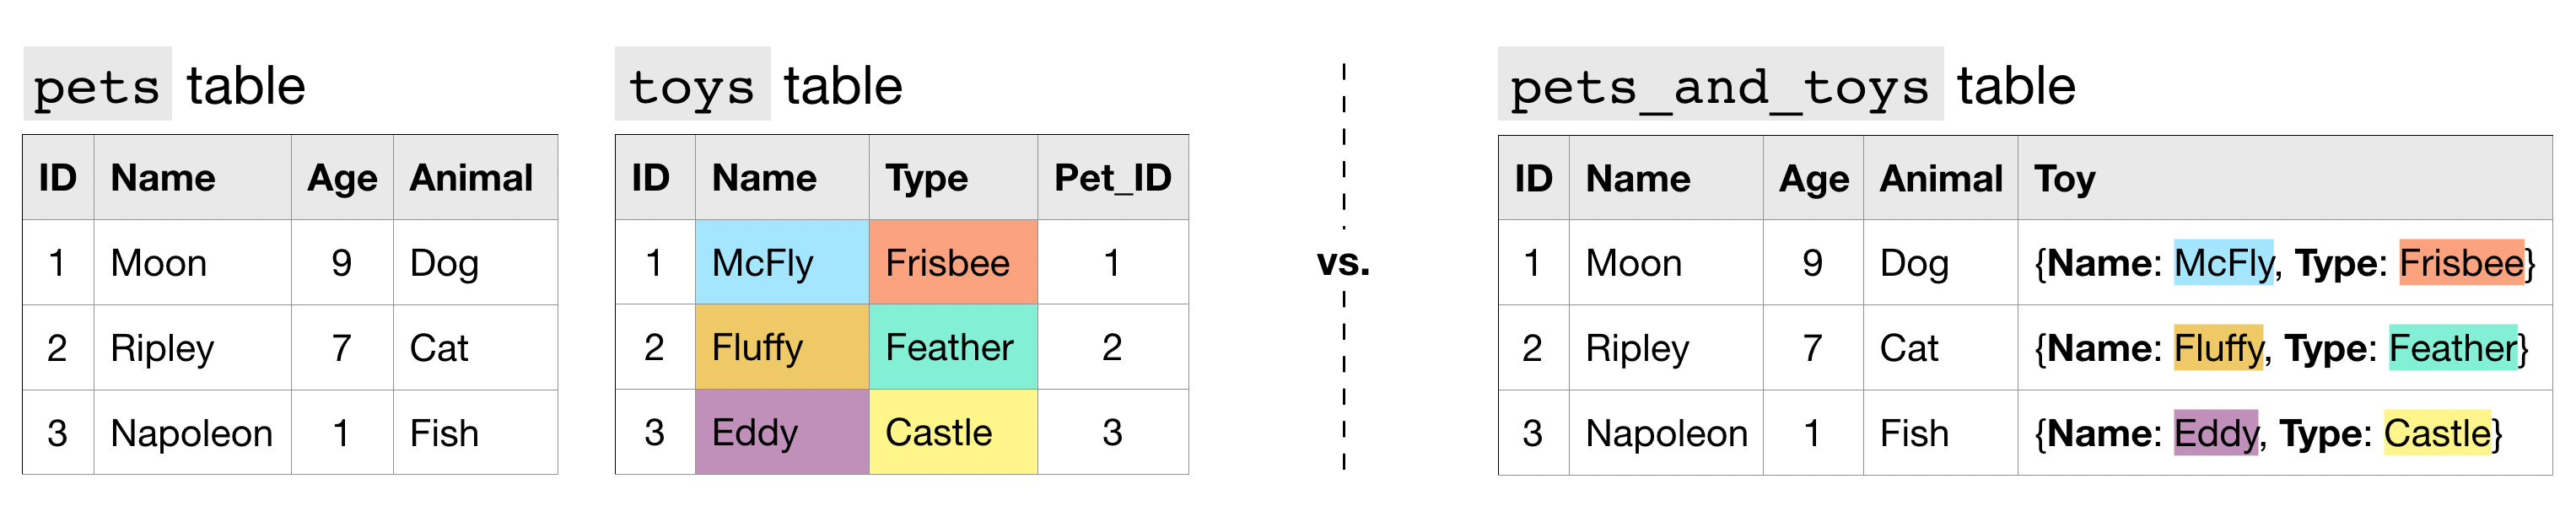


### Repeated data

Now consider the (more realistic!) case where each pet can have multiple toys. In this case, to collapse this information into a single table, we need to leverage a different datatype.
We say that the "Toys" column contains **repeated data**, because it permits more than one value for each row. This is reflected in the table schema below, where the mode of the "Toys" column appears as **'REPEATED'**.

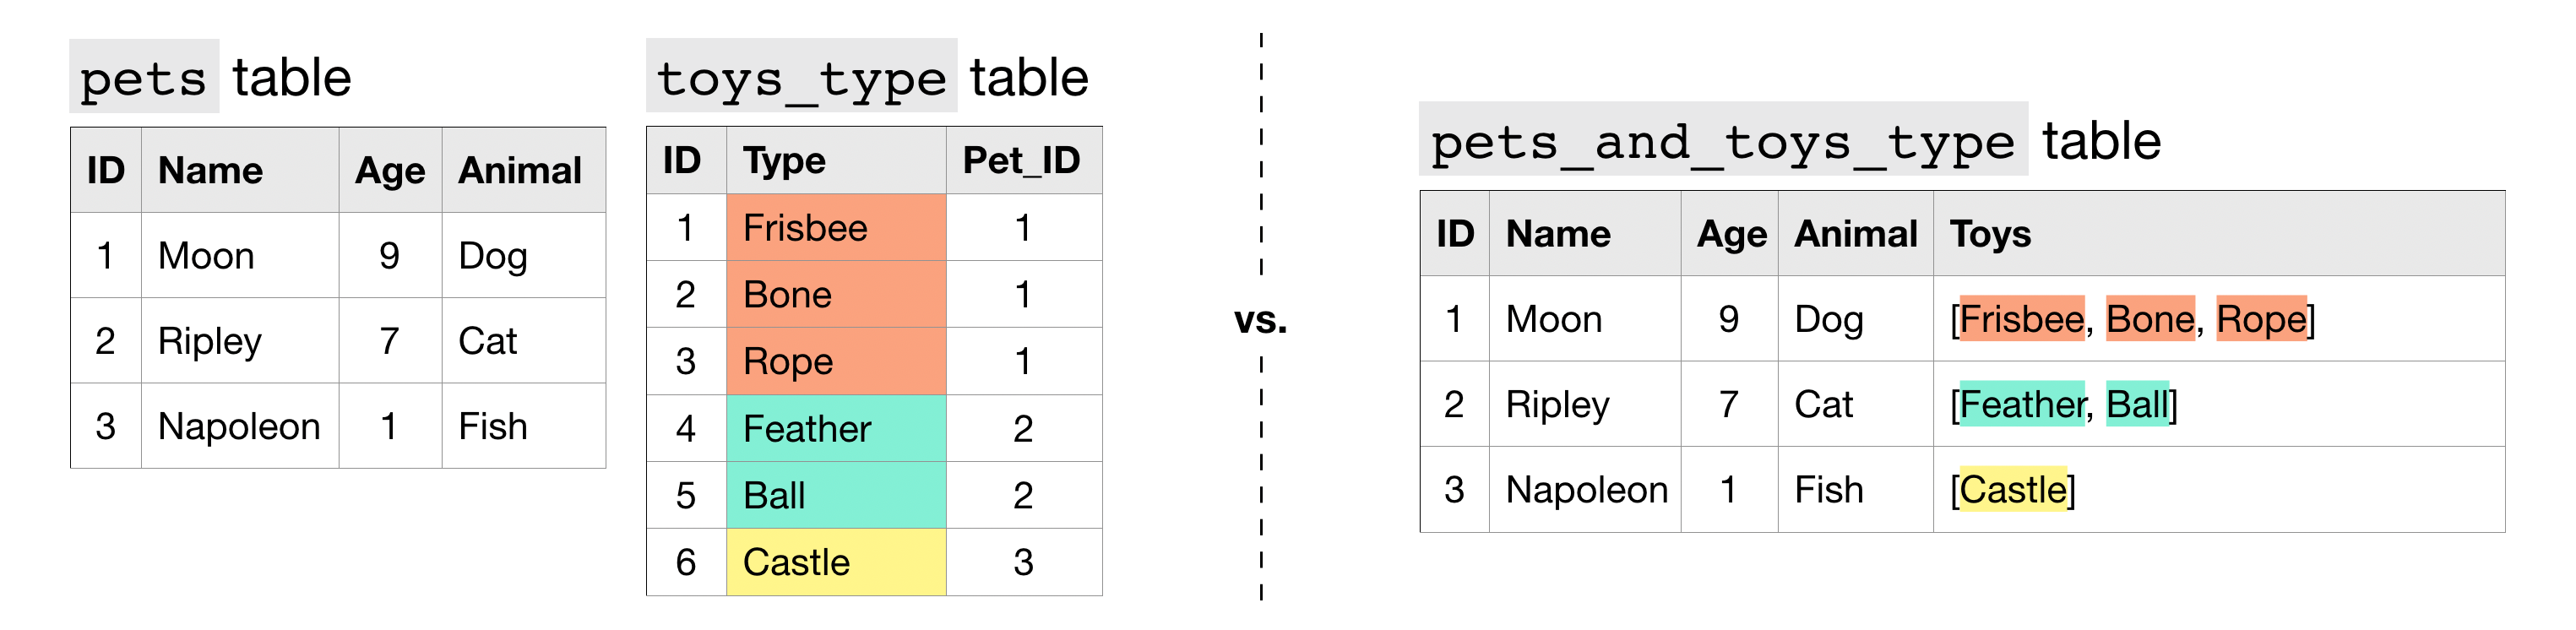

Each entry in a repeated field is an **ARRAY**, or an ordered list of (zero or more) values with the same datatype. For instance, the entry in the "Toys" column for Moon the Dog is [Frisbee, Bone, Rope], which is an ARRAY with three values.

When querying repeated data, we need to put the name of the column containing the repeated data inside an **UNNEST()** function.
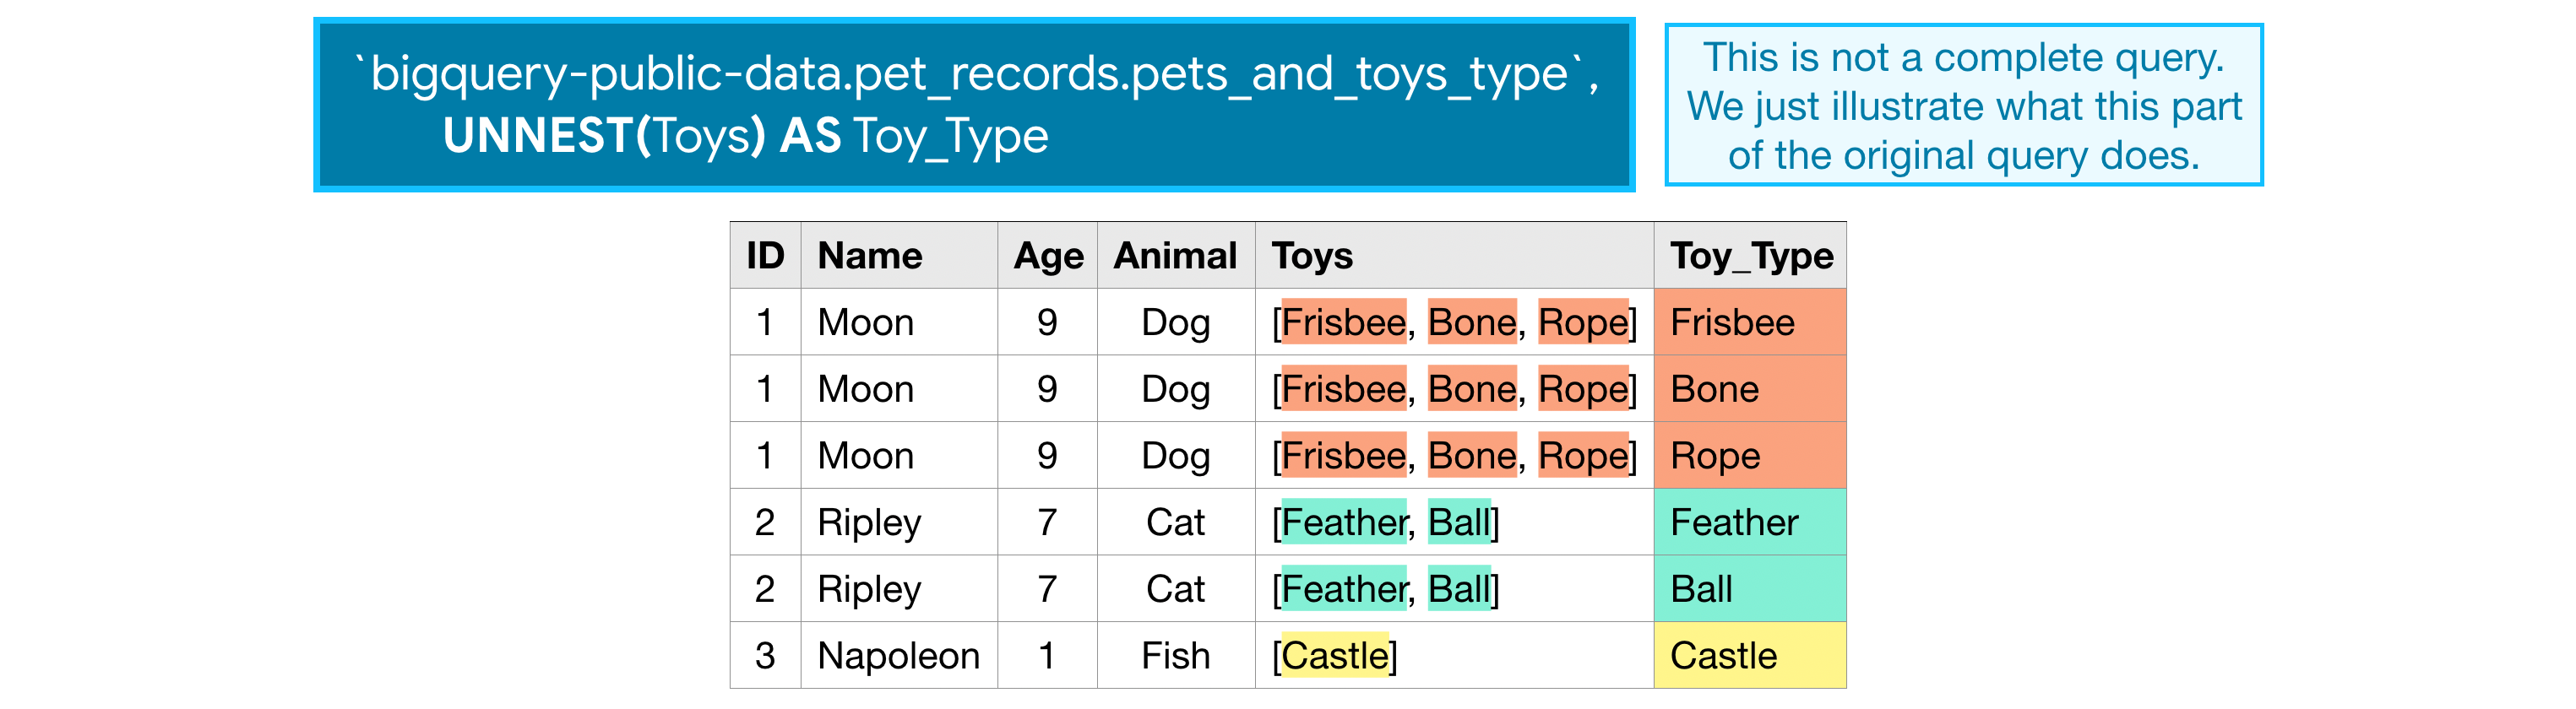

### Nested and repeated data
Now, what if pets can have multiple toys, and we'd like to keep track of both the name and type of each toy? In this case, we can make the "Toys" column both **nested and repeated**.
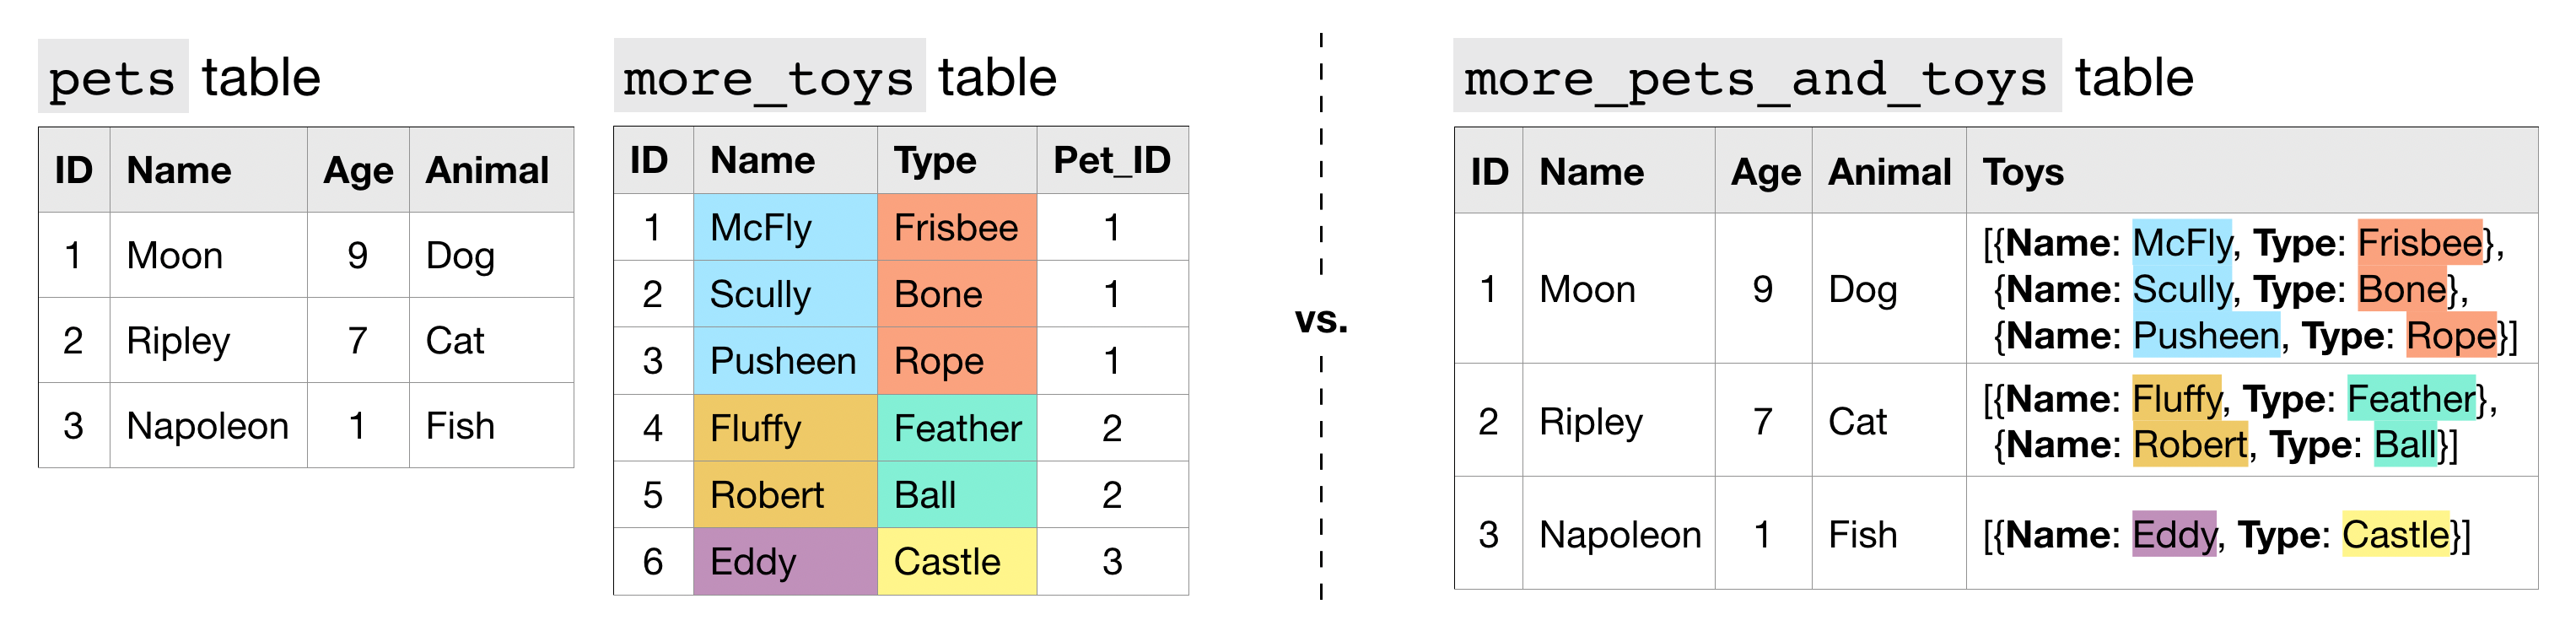

Let's look at a sample query.
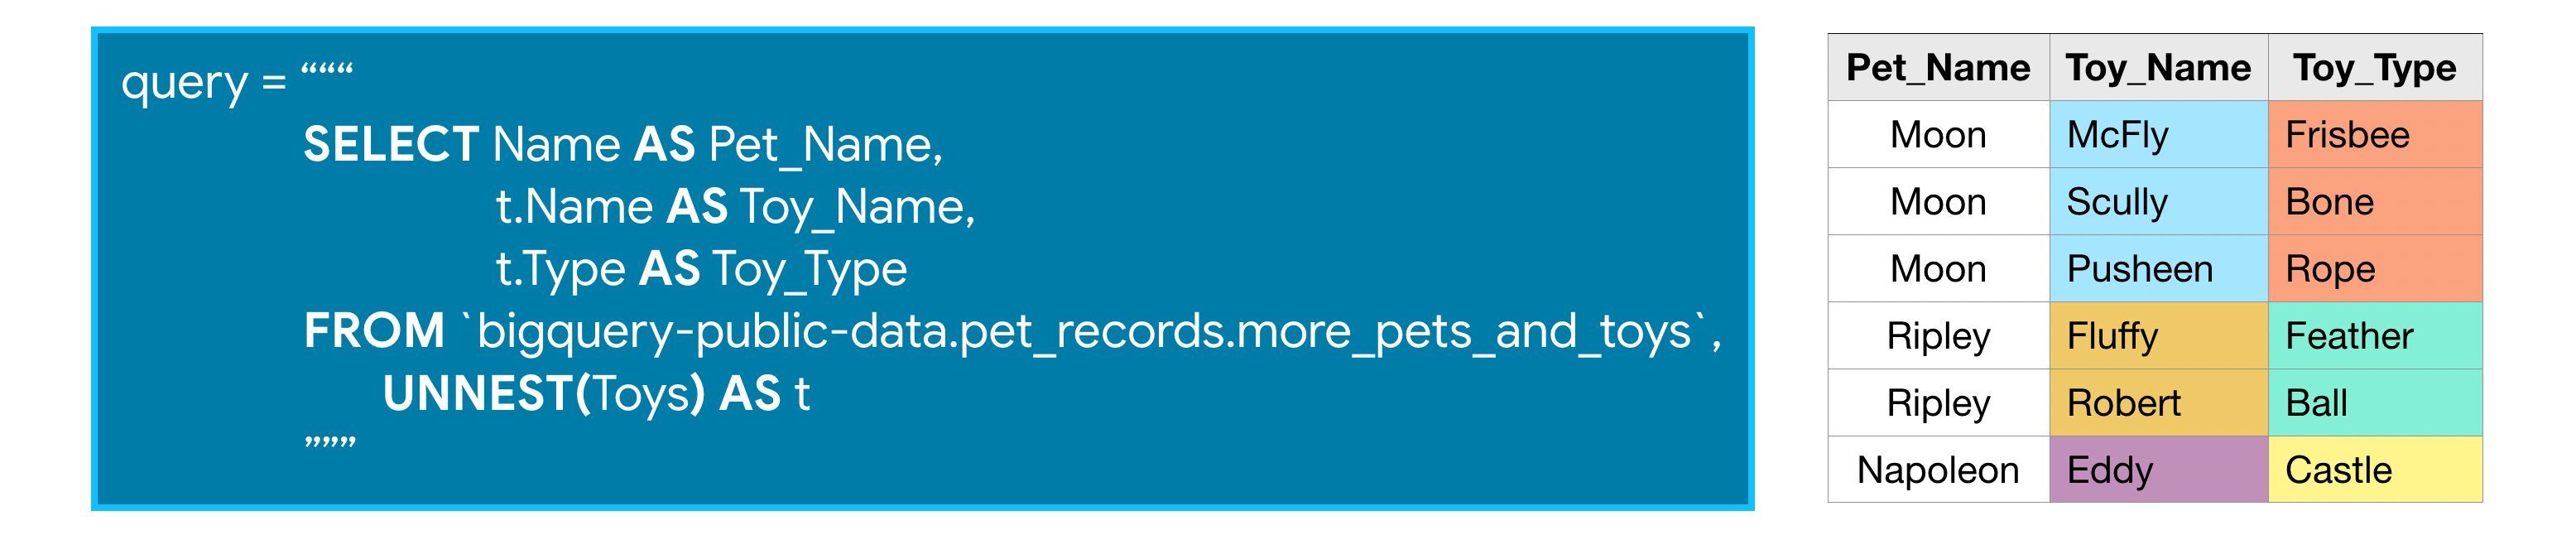
Since the "Toys" column is repeated, we flatten it with the **UNNEST()** function. And, since we give the flattened column an alias of t, we can refer to the "Name" and "Type" fields in the "Toys" column as t.Name and t.Type, respectively.

To reinforce what you've learned, we'll apply these ideas to a real dataset in the section below.

###  Exercise

#### 1) Who had the most commits in 2016?

GitHub is the most popular place to collaborate on software projects. A GitHub repository (or repo) is a collection of files associated with a specific project, and a GitHub commit is a change that a user has made to a repository. We refer to the user as a committer.

The sample_commits table contains a small sample of GitHub commits, where each row corresponds to different commit. The code cell below fetches the table and shows the first five rows of this table.

In [1]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "github_repos" dataset
dataset_ref = client.dataset("github_repos", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "sample_commits" table
table_ref = dataset_ref.table("sample_commits")

# API request - fetch the table
sample_commits_table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(sample_commits_table, max_results=5).to_dataframe()

ModuleNotFoundError: No module named 'google'

In [2]:
# Print information on all the columns in the table
sample_commits_table.schema

NameError: name 'sample_commits_table' is not defined

Write a query to find the individuals with the most commits in this table in 2016. Your query should return a table with two columns:

committer_name - contains the name of each individual with a commit (from 2016) in the table
num_commits - shows the number of commits the individual has in the table (from 2016)
Sort the table, so that people with more commits appear first.

NOTE: You can find the name of each committer and the date of the commit under the "committer" column, in the "name" and "date" child fields, respectively.

In [3]:
# Write a query to find the answer
max_commits_query = """
                    SELECT committer.name AS committer_name, COUNT(*) AS num_commits
                    FROM `bigquery-public-data.github_repos.sample_commits`
                    WHERE committer.date >= '2016-01-01' AND committer.date < '2017-01-01'
                    GROUP BY committer_name
                    ORDER BY num_commits DESC
                    """


#### 2) Look at languages!
Now you will work with the languages table. Run the code cell below to print the first few rows.

In [ ]:
# Construct a reference to the "languages" table
table_ref = dataset_ref.table("languages")

# API request - fetch the table
languages_table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(languages_table, max_results=5).to_dataframe()

Each row of the languages table corresponds to a different repository.

The "repo_name" column contains the name of the repository,
the "name" field in the "language" column contains the programming languages that can be found in the repo, and
the "bytes" field in the "language" column has the size of the files (in bytes, for the corresponding language).
Run the following code cell to print the table schema.

In [ ]:
# Print information on all the columns in the table
languages_table.schema

#### 3) What's the most popular programming language?
Write a query to leverage the information in the languages table to determine which programming languages appear in the most repositories. The table returned by your query should have two columns:

* language_name - the name of the programming language
* num_repos - the number of repositories in the languages table that use the programming language

Sort the table so that languages that appear in more repos are shown first.

In [4]:
# Write a query to find the answer
pop_lang_query = """
                 SELECT l.name as language_name, COUNT(*) as num_repos
                 FROM `bigquery-public-data.github_repos.languages`,
                     UNNEST(language) AS l
                 GROUP BY language_name
                 ORDER BY num_repos DESC
                 """


#### 4) Which languages are used in the repository with the most languages?
For this question, you'll restrict your attention to the repository with name 'polyrabbit/polyglot'.

Write a query that returns a table with one row for each language in this repository. The table should have two columns:

* name - the name of the programming language
* bytes - the total number of bytes of that programming language

Sort the table by the bytes column so that programming languages that take up more space in the repo appear first.

In [5]:
# Your code here
all_langs_query = """
                  SELECT l.name, l.bytes
                  FROM `bigquery-public-data.github_repos.languages`,
                      UNNEST(language) as l
                  WHERE repo_name = 'polyrabbit/polyglot'
                  ORDER BY l.bytes DESC
                  """


## 4. Writing Efficient Queries

### Strategies
#### 1) Only select the columns you want.

It is tempting to start queries with SELECT * FROM .... It's convenient because you don't need to think about which columns you need. But it can be very inefficient.

This is especially important if there are text fields that you don't need, because text fields tend to be larger than other fields.

#### 2) Read less data.
Both queries below calculate the average duration (in seconds) of one-way bike trips in the city of San Francisco.

In [ ]:
more_data_query = """
                  SELECT MIN(start_station_name) AS start_station_name,
                      MIN(end_station_name) AS end_station_name,
                      AVG(duration_sec) AS avg_duration_sec
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_id != end_station_id 
                  GROUP BY start_station_id, end_station_id
                  LIMIT 10
                  """
show_amount_of_data_scanned(more_data_query)

less_data_query = """
                  SELECT start_station_name,
                      end_station_name,
                      AVG(duration_sec) AS avg_duration_sec                  
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_name != end_station_name
                  GROUP BY start_station_name, end_station_name
                  LIMIT 10
                  """
show_amount_of_data_scanned(less_data_query)

Output: 

Data processed: 0.076 GB

Data processed: 0.06 GB

Since there is a 1:1 relationship between the station ID and the station name, we don't need to use the start_station_id and end_station_id columns in the query. By using only the columns with the station IDs, we scan less data.

#### 3) Avoid N:N JOINs.
Most of the JOINs that you have executed in this course have been **1:1 JOINs**. In this case, each row in each table has at most one match in the other table.

Another type of JOIN is an **N:1 JOIN**. Here, each row in one table matches potentially many rows in the other table.

Finally, an **N:N JOIN** is one where a group of rows in one table can match a group of rows in the other table. Note that in general, all other things equal, this type of JOIN produces a table with many more rows than either of the two (original) tables that are being JOINed.

Now we'll work with an example from a real dataset. Both examples below count the number of distinct committers and the number of files in several GitHub repositories.

In [11]:
big_join_query = """
                 SELECT repo,
                     COUNT(DISTINCT c.committer.name) as num_committers,
                     COUNT(DISTINCT f.id) AS num_files
                 FROM `bigquery-public-data.github_repos.commits` AS c,
                     UNNEST(c.repo_name) AS repo
                 INNER JOIN `bigquery-public-data.github_repos.files` AS f
                     ON f.repo_name = repo
                 WHERE f.repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                 GROUP BY repo
                 ORDER BY repo
                 """
##show_time_to_run(big_join_query)

small_join_query = """
                   WITH commits AS
                   (
                   SELECT COUNT(DISTINCT committer.name) AS num_committers, repo
                   FROM `bigquery-public-data.github_repos.commits`,
                       UNNEST(repo_name) as repo
                   WHERE repo IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   ),
                   files AS 
                   (
                   SELECT COUNT(DISTINCT id) AS num_files, repo_name as repo
                   FROM `bigquery-public-data.github_repos.files`
                   WHERE repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   )
                   SELECT commits.repo, commits.num_committers, files.num_files
                   FROM commits 
                   INNER JOIN files
                       ON commits.repo = files.repo
                   ORDER BY repo
                   """

## show_time_to_run(small_join_query)

Output:

Time to run: 13.028 seconds

Time to run: 4.413 seconds

The first query has a large N:N JOIN. By rewriting the query to decrease the size of the JOIN, we see it runs much faster.

